## 목표

1. 3가지 이상의 모델이 성공적으로 시도됨
2. gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함
3. 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함





In [6]:
import pandas
import konlpy
import gensim
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

1.3.3
0.5.2
4.1.2


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

1. 데이터의 중복 제거
2. NaN 결측치 제거
3. 한국어 토크나이저로 토큰화 + 불용어(Stopwords) 제거
4. 사전word_to_index 구성
5. 텍스트 스트링을 사전 인덱스 스트링으로 변환
6. X_train, y_train, X_test, y_test, word_to_index 리턴

In [21]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']  # 불용어 제거
num_words = 20000  

def load_data(train_data, test_data, num_words=num_words):
    # 1. 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    # 2. 결측치(NaN) 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')

    # 3. 한국어 토큰화 및 불용어 제거
    def preprocess_text(texts):
        tokenized_texts = []
        for sentence in texts:
            if isinstance(sentence, str):  # 문자열인지 확인 (NaN 방지)
                tokens = tokenizer.morphs(sentence)  
                tokens = [word for word in tokens if word not in stopwords]  # 불용어 제거
                tokenized_texts.append(tokens)
        return tokenized_texts

    X_train_tokens = preprocess_text(train_data['document'])
    X_test_tokens = preprocess_text(test_data['document'])

    # 4. 사전 word_to_index 구성
    words = [word for sentence in X_train_tokens for word in sentence]  #단어추출
    word_counts = Counter(words)  # 단어 빈도수 계산
    most_common_words = word_counts.most_common(num_words - 4)  

    # 특수 토큰을 먼저 추가
    word_to_index = {
        "<PAD>": 0,  # 패딩 (Padding)
        "<BOS>": 1,  # 문장의 시작 (Beginning of Sentence)
        "<UNK>": 2,  # 모르는 단어 (Unknown)
        "<UNUSED>": 3  # 추가적으로 사용할 수 있는 예약된 인덱스
    }

    # 일반 단어 인덱싱 (4부터 시작)
    for i, (word, _) in enumerate(most_common_words, start=4):
        word_to_index[word] = i

    # 5. 텍스트 스트링을 사전 인덱스 스트링으로 변환 (문장 앞에 <BOS> 추가)
    def text_to_sequence(tokenized_texts):
        sequences = []
        for sentence in tokenized_texts:
            sequence = [1] + [word_to_index.get(word, 2) for word in sentence]  
            sequences.append(sequence)
        return sequences

    X_train = text_to_sequence(X_train_tokens)
    X_test = text_to_sequence(X_test_tokens)

    y_train = np.array(train_data['label'])  # 라벨 변환
    y_test = np.array(test_data['label'])

    return X_train, y_train, X_test, y_test, word_to_index

# 데이터 로드 실행
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

lms에서 제공해주는 함수

In [22]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공
데이터셋 내 문장 길이 분포

적절한 최대 문장 길이 지정

keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44600 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_

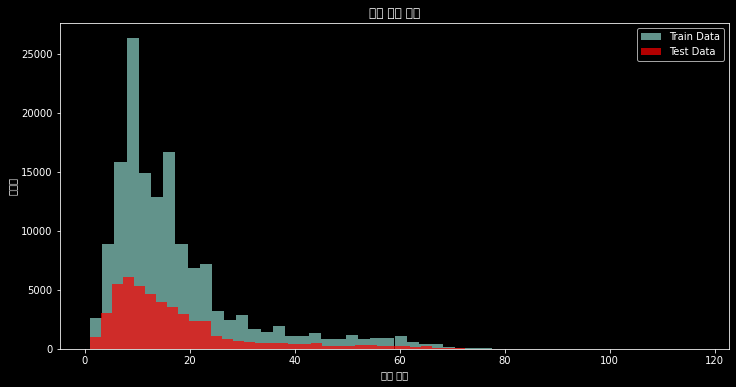

In [23]:
import matplotlib.font_manager as fm

# 문장 길이 계산
train_lengths = [len(sentence) for sentence in X_train]
test_lengths = [len(sentence) for sentence in X_test]

# 히스토그램 그리기
plt.rc('font', family='Nanum Gothic')  
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
plt.hist(train_lengths, bins=50, alpha=0.7, label="Train Data")
plt.hist(test_lengths, bins=50, alpha=0.7, label="Test Data", color='red')
plt.xlabel("문장 길이")
plt.ylabel("빈도수")
plt.legend()
plt.title("문장 길이 분포")
plt.show()

좀 꺠지네요... x가 문장길이 y가 빈도수 입니다.

0에서 30 저도 사이에 최대로 몰려있는것을 볼 수 있습니다.


In [28]:
# lms에서 문장길이 지정한 것.

total_data_text = list(X_train) + list(X_test)

#텍스트데이터 문장길이의 리스트를 생성한 후

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

#문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

 #예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
 
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  16.96940191154864
문장길이 최대 :  117
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  42
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


## b. 적절한 최대 문장 길이 지정

In [24]:
# 95% 문장이 포함되는 길이 찾기
maxlen = int(np.percentile(train_lengths, 95))
print(f"설정할 maxlen 값: {maxlen}")

설정할 maxlen 값: 48


## c. keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [25]:
# 패딩 적용
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(X_train, maxlen=maxlen, padding='pre')  #lms에서 pre가 더 좋다고 공부했었음!
X_test_padded = pad_sequences(X_test, maxlen=maxlen, padding='pre')

print("패딩 적용 후 X_train 크기:", X_train_padded.shape)
print("패딩 적용 후 X_test 크기:", X_test_padded.shape)

패딩 적용 후 X_train 크기: (146182, 48)
패딩 적용 후 X_test 크기: (49157, 48)


48로 되었음을 확인

### 4) 모델 구성 및 validation set 구성

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.


In [26]:
from sklearn.model_selection import train_test_split

# Validation Set 분리 (훈련 데이터의 20%를 검증 데이터로 사용)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_padded, y_train, test_size=0.2, random_state=42
)



훈련 데이터 크기: (116945, 48), 레이블 크기: (116945,)
검증 데이터 크기: (29237, 48), 레이블 크기: (29237,)


## lstm

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# 모델 LSTM 모델
model1 = Sequential([
    Embedding(input_dim=20000, output_dim=16, input_length=maxlen),
    LSTM(64, return_sequences=False),  # 단일 LSTM 층 lms에서는 8층으로 하였음.
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # 이진 분류
])

# 모델 컴파일
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 42, 16)            160000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 184,961
Trainable params: 184,961
Non-trainable params: 0
_________________________________________________________________


## GRU   (lstm보다는 조금더 가벼운 모델?)

In [42]:
from keras.layers import GRU

# 모델 2: GRU 기반 모델
model2 = Sequential()
model2.add((Embedding(input_dim=20000, output_dim=12, input_length=maxlen)))  # Embedding Layer
model2.add(GRU(8))  # GRU 레이어 (출력 벡터 차원 8)
model2.add(Dense(8, activation='relu'))  # Fully Connected Layer
model2.add(Dropout(0.5))  # 과적합 방지
model2.add(Dense(1, activation='sigmoid'))  # 이진 분류 (긍정/부정)

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 구조 출력
model2.summary()



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 42, 12)            120000    
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 528       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 120,609
Trainable params: 120,609
Non-trainable params: 0
_________________________________________________________________


# CNN 기반 모델

In [43]:
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

# 모델 3: CNN 기반 모델
model3 = Sequential()
model3.add(((Embedding(input_dim=20000, output_dim=12, input_length=maxlen))))  # Embedding Layer
model3.add(Conv1D(8, 5, activation='relu'))  # CNN 필터 적용
model3.add(MaxPooling1D())  # Max Pooling 적용
model3.add(GlobalMaxPooling1D())  
model3.add(Dense(8, activation='relu'))  # Fully Connected Layer
model3.add(Dropout(0.5))  # 과적합 방지
model3.add(Dense(1, activation='sigmoid'))  # 이진 분류 (긍정/부정)

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 구조 출력
model3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 42, 12)            120000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 38, 8)             488       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 8)             0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [52]:
# LSTM 모델 학습
history1 = model1.fit(X_train_final, y_train_final, epochs=20, batch_size=64, validation_data=(X_val, y_val))

# GRU 모델 학습
history2 = model2.fit(X_train_final, y_train_final, epochs=20, batch_size=64, validation_data=(X_val, y_val))

# CNN 모델 학습
history3 = model3.fit(X_train_final, y_train_final, epochs=20, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/30
1828/1828 [==============================] - 10s 5ms/step - loss: 0.0277 - accuracy: 0.9876 - val_loss: 1.5517 - val_accuracy: 0.8281
Epoch 2/30
1828/1828 [==============================] - 10s 5ms/step - loss: 0.0269 - accuracy: 0.9879 - val_loss: 1.7515 - val_accuracy: 0.8256
Epoch 3/30
1828/1828 [==============================] - 10s 5ms/step - loss: 0.0249 - accuracy: 0.9887 - val_loss: 1.8089 - val_accuracy: 0.8298
Epoch 4/30
1828/1828 [==============================] - 10s 5ms/step - loss: 0.0243 - accuracy: 0.9886 - val_loss: 1.7250 - val_accuracy: 0.8280
Epoch 5/30
1828/1828 [==============================] - 10s 5ms/step - loss: 0.0248 - accuracy: 0.9887 - val_loss: 1.6542 - val_accuracy: 0.8274
Epoch 6/30
1828/1828 [==============================] - 10s 5ms/step - loss: 0.0238 - accuracy: 0.9892 - val_loss: 1.6076 - val_accuracy: 0.8304
Epoch 7/30
1828/1828 [==============================] - 10s 5ms/step - loss: 0.0223 - accuracy: 0.9895 - val_loss: 1.7642 - val_ac

In [58]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test_padded = pad_sequences(X_test, maxlen=maxlen, padding='pre')

results1 = model1.evaluate(X_test_padded,y_test, verbose=2)
results2 = model2.evaluate(X_test_padded,y_test, verbose=2)
results3 = model3.evaluate(X_test_padded,y_test, verbose=2)

1537/1537 - 4s - loss: 2.1547 - accuracy: 0.8252
1537/1537 - 3s - loss: 1.1849 - accuracy: 0.8194
1537/1537 - 3s - loss: 1.6369 - accuracy: 0.8034


## Loss, Accurancy 시각화

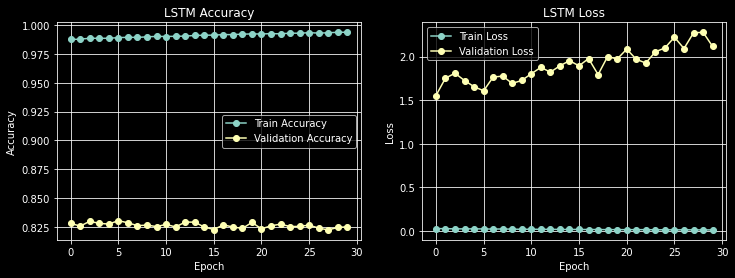

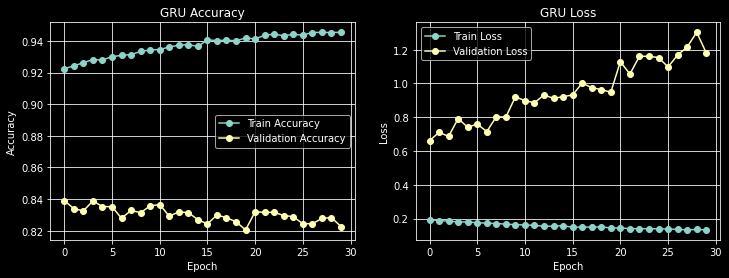

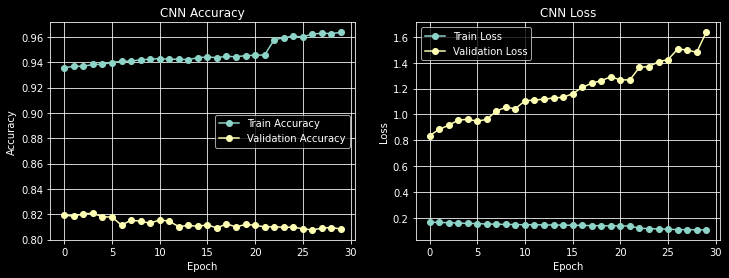

In [59]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()
    plt.grid(True)

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.grid(True)

    plt.show()
    
# LSTM 모델
plot_training_history(history1, "LSTM")

# GRU 모델
plot_training_history(history2, "GRU")

# CNN 모델
plot_training_history(history3, "CNN")


In [70]:
import os
import numpy as np
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 모델의 임베딩 레이어 가져오기
vocab_size = 10000
word_vector_dim = 16

embedding_layer = model1.layers[0]  # 첫 번째 레이어 (Embedding)
weights = embedding_layer.get_weights()[0]  # 학습된 가중치 가져오기
print(weights.shape)  # (vocab_size, embedding_dim) 형태

# 저장할 파일 경로 설정
word2vec_file_path = os.path.join(os.getcwd(), "word2vec.txt")

# Word2Vec 형식으로 저장
with open(word2vec_file_path, 'w') as f:
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 총 단어 개수 및 벡터 차원
    for i in range(4, vocab_size):  # 특수 토큰 제외
        word = index_to_word.get(i, None)
        if word:
            vector_str = ' '.join(map(str, weights[i]))
            f.write('{} {}\n'.format(word, vector_str))

print(f"✅ 학습된 Word2Vec 파일이 저장되었습니다: {word2vec_file_path}")




(10000, 16)


[('빨려', 0.9863371849060059),
 ('각지', 0.986009418964386),
 ('퍼펙트', 0.9831481575965881),
 ('헌신', 0.9802070260047913),
 ('외로움', 0.9799637794494629),
 ('It', 0.9798745512962341),
 ('기다려집니다', 0.9777265787124634),
 ('찰스', 0.9776760339736938),
 ('균', 0.9766098260879517),
 ('매체', 0.9762482047080994)]

In [71]:
# Word2Vec 포맷의 학습된 임베딩 로드
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

# 특정 단어의 벡터 확인 (예: "love")
word = "love"
if word in word_vectors:
    print(f"'{word}'의 벡터값:\n{word_vectors[word]}")

    # 유사한 단어 찾기
    print(f"\n'{word}'와 유사한 단어 (자체 학습된 임베딩):")
    print(word_vectors.similar_by_word(word))
else:
    print(f"'{word}' 단어가 존재하지 않습니다.")


'love'의 벡터값:
[-0.68575126 -0.9145558   0.6807802   0.2660935   0.5348725   0.28903225
  0.61397105  0.74538434 -0.52890694  0.8150422  -0.07807823 -0.6197013
  0.97027963  0.9656353   0.16992949  0.6237192 ]

'love'와 유사한 단어 (자체 학습된 임베딩):
[('빨려', 0.9863371849060059), ('각지', 0.986009418964386), ('퍼펙트', 0.9831481575965881), ('헌신', 0.9802070260047913), ('외로움', 0.9799637794494629), ('It', 0.9798745512962341), ('기다려집니다', 0.9777265787124634), ('찰스', 0.9776760339736938), ('균', 0.9766098260879517), ('매체', 0.9762482047080994)]


In [74]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.


word2vec.similar_by_word("love")


[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

영어라서 의미가 있는지 확인해야될 것 같습니다. 한글로 된 걸로 해야되는데 시간이 부족합니다.... 

In [76]:
vocab_size = 20000  # 단어 사전 크기 증가
word_vector_dim = 300  # Word2Vec에서 가져온 임베딩 차원
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for word, i in word_to_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# 모델 구성
model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False))  # Word2Vec 가중치 적용
model.add(Conv1D(64, 5, activation='relu'))  # CNN 추가
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, return_sequences=True))  # LSTM 계층 증가
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))  # 과적합 방지
model.add(Dense(1, activation='sigmoid'))  # 감성 분석 (이진 분류)

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 구조 확인
model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 42, 300)           6000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 38, 64)            96064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 19, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)               

In [ ]:
from sklearn.model_selection import train_test_split


# 데이터 나누기
X_train, X_val, y_train, y_val = train_test_split(X_train_final, y_train_final, test_size=0.2, random_state=42)
X_train = pad_sequences(X_train, maxlen=42, padding='pre')
X_test = pad_sequences(X_test, maxlen=42, padding='pre')
# 모델 학습
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))


In [ ]:
results = model.evaluate(X_test, y_test, verbose=2)
print(f"\n✅ 모델 성능: 정확도 {results[1]*100:.2f}%")

### 회고록

조금 힘들었습니다. 이해하면서 하느라고 좀 더 구현하지 못한게 아쉽습니다.
저번시간에 했던 자동으로 하이퍼파라미터 조정하는걸 써보고 싶었는데 아쉽습니다.